In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt

from scipy.stats import randint
from scipy.special import boxcox
from scipy.special import inv_boxcox

pd.set_option('display.max_columns', None)

D:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calculate_alpha_beta(mean,var):
    return var/mean , mean/(var/mean)

In [3]:
def pearson_corr_2(x, y):
    x_diff = x - np.mean(x)
    y_diff = y - np.mean(y)
    r2_c = (np.dot(x_diff, y_diff) / (np.sqrt(sum(x_diff ** 2)) * np.sqrt(sum(y_diff ** 2)))) ** 2
    return r2_c

In [4]:
def check_deviation(group):
    values = group['Est_AC_POWER'].values
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            if abs(values[i] - values[j]) / max(values[i], values[j]) > 0.5:
                return True
    return False

In [5]:
# dataset = pd.read_csv('dataset.csv')
dataset = pd.read_csv('cleand_dataset.csv')
dataset.tail()

,Unnamed: 0.1,Unnamed: 0,TRIP_ID,SUB_ID,SEGMENT_ID,START_TIME,END_TIME,START_LATITUDE,START_LONGITUDE,LAST_LATITUDE,LAST_LONGITUDE,START_ALTITUDE,LAST_ALTITUDE,AVG_ALTITUDE,START_SOC,END_SOC,START_GIDS,END_GIDS,SOH,AVG_SPEED,RUN_TIME,TRIP_TIME,DROP_TIME,BETTERY_TEMPERATURA,AMBIENT_TEMPERATURA,EV_POWER,RUN_POWER,AUX_POWER,AC_POWER,Est_AC_POWER,ALL_Consumption_Wh,RUN_Consumption_Wh,AUX_Consumption_Wh,AC_Consumption_Wh,EST_AC_Consumption_Wh,TEMPERATURE_yokohama,TEMPERATURE_ebina,HUMIDITY,WIND_SPEED_yokohama,WIND_SPEED_ebina,ILLUMINANCE,PRECIPITATION_START_yokohama,PRECIPITATION_END_yokohama,PRECIPITATION_START_ebina,PRECIPITATION_END_ebina,WEATHER,ILLUMINANCE_Log,TRIP_TEMPERATURE,AVG_TEMPERATURE,AVG_PRECIPITATION_START,AVG_PRECIPITATION_END
15347,17464,17464,4560,1,22,2023-08-30 10:50:00,2023-08-30 10:50:00,35.449129,139.567853,35.452739,139.576851,57.7,64.2,59.858333,728318,726240,522,521,91.97,70.764000,3817.0,51.0,0.0,32.358333,32.833333,8988.018412,8038.018412,200.000000,750.000000,666.666667,123.898511,110.440178,2.833333,10.625000,9.444444,31.9,31.799999,20.857681,5.20,3.5,38488.187489,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,31.849999,0.0,0.0
15348,17465,17465,4560,1,23,2023-08-30 10:50:00,2023-08-30 11:00:00,35.452996,139.577632,35.458544,139.585216,60.5,34.8,46.375000,726224,726472,521,521,91.97,70.881001,3868.0,51.0,0.0,32.366667,33.000000,-1109.831677,-2059.831677,200.000000,750.000000,716.666667,-15.617443,-29.075777,2.833333,10.625000,10.166667,31.9,31.974999,21.109992,5.15,3.4,37195.114358,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,31.937500,0.0,0.0
15349,17466,17466,4560,1,24,2023-08-30 11:00:00,2023-08-30 11:00:00,35.459174,139.585967,35.465691,139.591233,32.4,24.4,24.725000,726530,725422,521,520,91.97,69.768000,3918.0,50.0,0.0,32.386111,33.291667,4570.528872,3620.528872,200.000000,750.000000,720.833333,62.262229,49.067784,2.777778,10.416667,10.000000,31.9,32.500000,21.866924,5.00,3.1,33315.894966,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,32.200000,0.0,0.0
15350,17467,17467,4560,1,25,2023-08-30 11:00:00,2023-08-30 11:00:00,35.466307,139.591511,35.472796,139.595000,25.8,49.0,42.200000,725100,722048,520,518,91.97,27.947172,4047.0,129.0,0.0,32.440230,33.500000,4200.582567,3250.582567,200.000000,750.000000,743.103448,132.393101,98.351435,7.166667,26.875000,26.527778,31.9,32.500000,21.866924,5.00,3.1,33315.894966,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,32.200000,0.0,0.0
15351,17468,17468,4560,1,26,2023-08-30 11:00:00,2023-08-30 11:00:00,35.472929,139.594838,35.472286,139.586766,49.3,50.9,48.887097,721812,718416,518,515,91.97,15.419032,4310.0,263.0,0.0,32.493011,33.233871,2664.847759,1729.363888,217.741935,717.741935,740.322581,192.796632,124.282743,15.944444,52.569444,54.180556,31.9,32.500000,21.866924,5.00,3.1,33315.894966,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,32.200000,0.0,0.0


In [6]:
features = ['RUN_TIME','DROP_TIME','AVG_SPEED','AVG_ALTITUDE','AVG_TEMPERATURE','HUMIDITY','ILLUMINANCE_Log','AVG_PRECIPITATION_START','AVG_PRECIPITATION_END']
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

dataset_groupby = dataset.groupby(['TRIP_ID']).sum(numeric_only=True)
id_list = dataset_groupby[(dataset_groupby['EST_AC_Consumption_Wh']>50)].index.tolist()
dataset = dataset[dataset['TRIP_ID'].isin(id_list)]

DBSCANを用いて、特徴量が類似しているが、目標値に大きな差異があるデータを除外しました（モデルを適用した結果が良くなかったため、採用しません）。

In [7]:
# cluster_df = dataset[features].copy()
# clustering = DBSCAN(eps=3, min_samples=2).fit(cluster_df)
# cluster_df['cluster'] = clustering.labels_

# Outliers_df = cluster_df[cluster_df['cluster'] != -1]
# Outliers_df = Outliers_df.join(dataset[['TRIP_ID','Est_AC_POWER']])
# remove_outliers = Outliers_df.groupby('cluster').filter(check_deviation)

# id_list = list(remove_outliers['TRIP_ID'].unique())
# dataset_remove_by_DBSCAN = dataset[dataset['TRIP_ID'].isin(id_list)]

グリッドサーチ

In [8]:
param_grid = {
    'n_estimators': list(range(20, 151, 10)),
    'learning_rate': [0.01, 0.31, 0.05]
}

lgb = lgb.LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(poly.fit_transform(dataset[features]), boxcox(dataset['Est_AC_POWER'], 0.24))

print("best params:", grid_search.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9349
[LightGBM] [Info] Number of data points in the train set: 14188, number of used features: 45
[LightGBM] [Info] Start training from score 11.634942
best params: {'learning_rate': 0.05, 'n_estimators': 80}


ランダムサーチ

In [9]:
# param_distributions = {
#     'n_estimators': randint(10, 200),
#     'max_depth': [None] + list(range(10, 31, 10)),
#     'min_samples_split': randint(2, 10)
# }

# rf = RandomForestRegressor()
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=50, cv=3, n_jobs=-1, random_state=99)
# random_search.fit(poly.fit_transform(dataset[features]), boxcox(dataset['Est_AC_POWER'], 0.24))
# print("best params:", random_search.best_params_)

10分割交差検定
特徴量を多項式変換
目標値をboxcox変換

In [10]:
dataset.reset_index(inplace=True)
kfold_groups = dataset['TRIP_ID'].unique()
kf = KFold(n_splits=10, shuffle=True, random_state=50)

result_real = []
result_pred = []

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'device': 'gpu',
    'learning_rate': grid_search.best_params_['learning_rate'],
    'gpu_platform_id': 0,
    'gpu_device_id': 0
}

for train_index, test_index in kf.split(kfold_groups):

    train = dataset[dataset['TRIP_ID'].isin(kfold_groups[train_index])]
    test = dataset[dataset['TRIP_ID'].isin(kfold_groups[test_index])]
    
    X_train = poly.fit_transform(train[features])
    X_test = poly.fit_transform(test[features])
    
    Y_train = train['Est_AC_POWER']
    Y_test = test['Est_AC_POWER']
    
    Y_train = boxcox(train['Est_AC_POWER'], 0.24)
    Y_test = boxcox(test['Est_AC_POWER'], 0.24)
    
    lightgbm = LGBMRegressor(learning_rate=grid_search.best_params_['learning_rate'],
                                 n_estimators=grid_search.best_params_['n_estimators'],
                                 device='gpu',
                                 gpu_platform_id=0,
                                 gpu_device_id=0)
    
    lightgbm.fit(X_train,Y_train)
    Y_pred = lightgbm.predict(X_test)
    
    
#     result_real.append(list(Y_test))
#     result_pred.append(list(Y_pred))
#     dataset.loc[test.index, 'Pred_AC_POWER'] = list(Y_pred)
    
    result_real.append(list(inv_boxcox(Y_test, 0.24)))
    result_pred.append(list(inv_boxcox(Y_pred, 0.24)))
    dataset.loc[test.index, 'Pred_AC_POWER'] = list(inv_boxcox(Y_pred, 0.24))

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 12755, number of used features: 45
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.29 MB) transferred to GPU in 0.001760 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 11.659280
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 9156
[LightGBM] [Info] Number of data points in the train set: 12817, number of used features: 45
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling Open

In [11]:
print('rmse:',sqrt(mean_squared_error(dataset['Est_AC_POWER'],dataset['Pred_AC_POWER'])))
print('r2:',r2_score(dataset['Est_AC_POWER'],dataset['Pred_AC_POWER']))

rmse: 159.01751563174804
r2: 0.714746702562364


In [12]:
df_result = dataset.copy()
df_result['Real_Wh'] = list(df_result.Est_AC_POWER*df_result.TRIP_TIME/3600)
df_result['Pred_Wh'] = list(df_result.Pred_AC_POWER*df_result.TRIP_TIME/3600)
print(r2_score(df_result['Real_Wh'].tolist(),df_result['Pred_Wh'].tolist()))
print(pearson_corr_2(df_result['Real_Wh'].tolist(),df_result['Pred_Wh'].tolist()))

0.8213521329776232
0.82678971935887


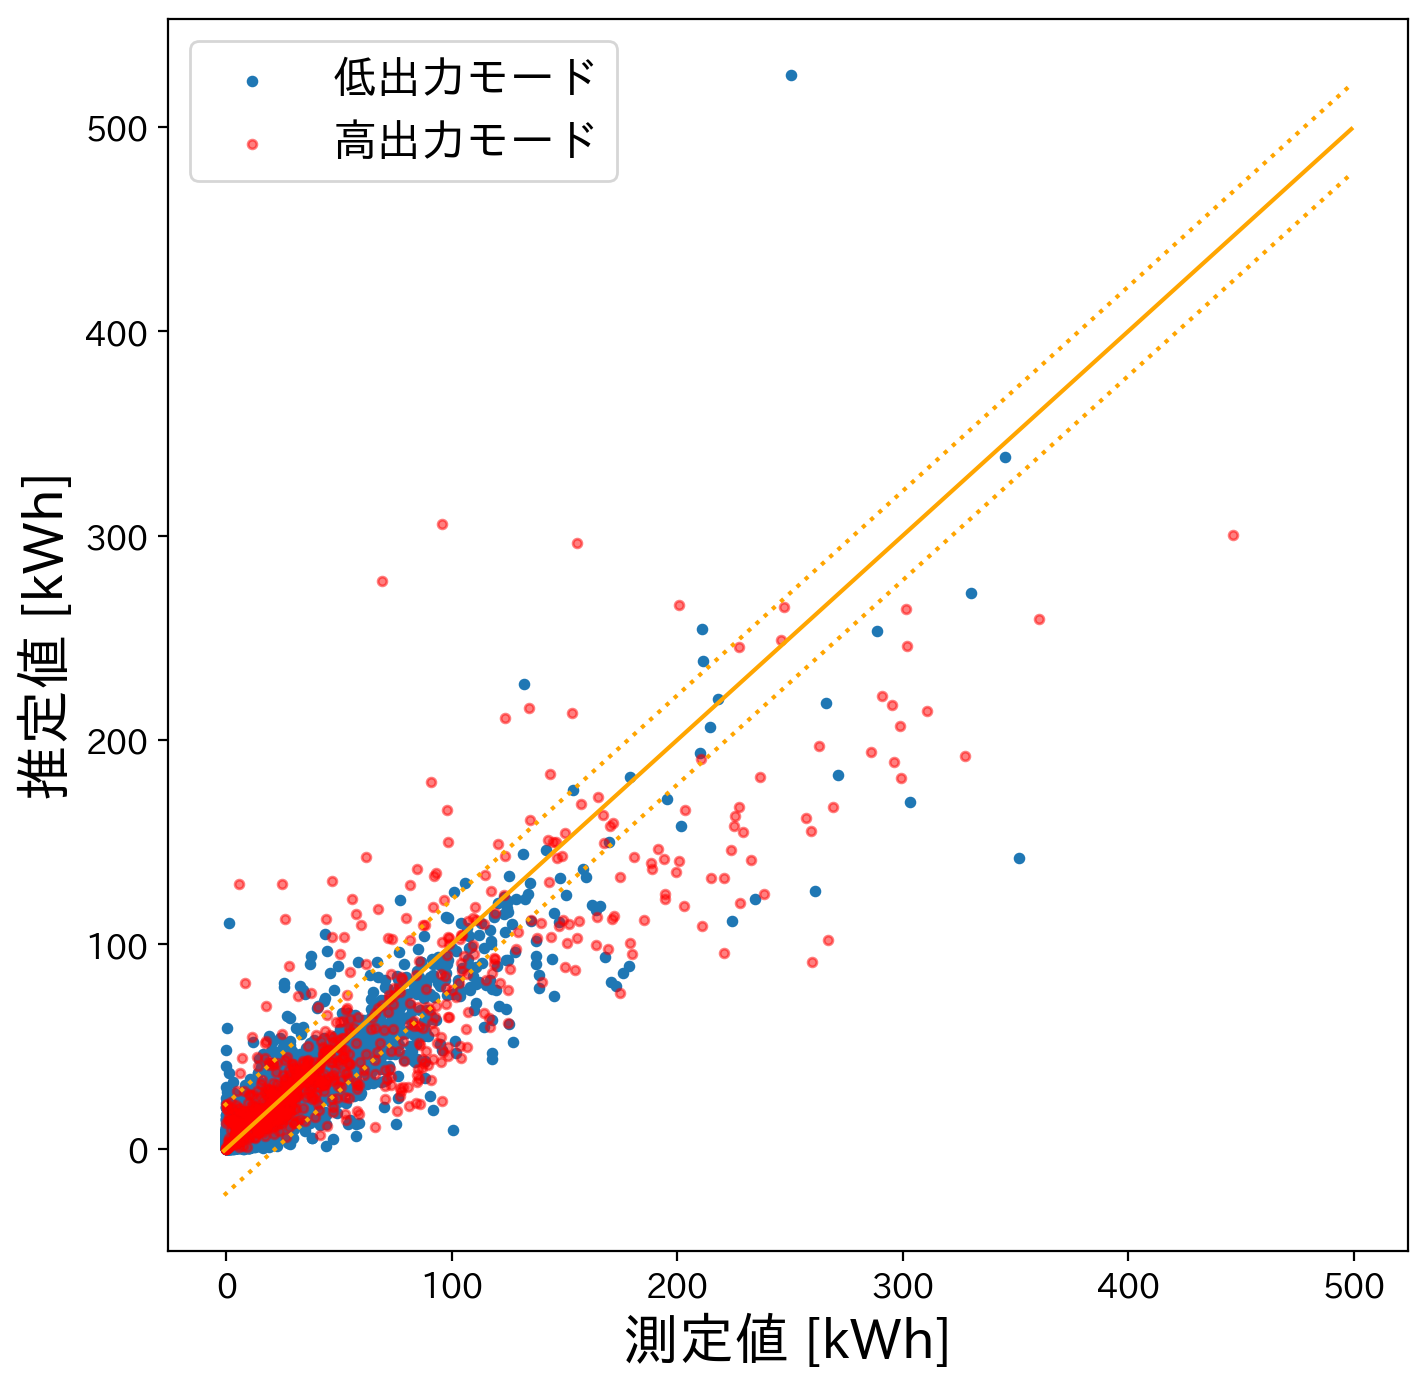

In [13]:
high_model = df_result[df_result['DROP_TIME'] != 0]
low_model = df_result[df_result['DROP_TIME'] == 0]
rmse = sqrt(mean_squared_error(df_result['Real_Wh'], df_result['Pred_Wh']))

plt.figure(figsize=(8, 8),dpi=200)
x = np.arange(-1, 500, 1)
y1 = x
plt.plot(x, y1, color='orange')
plt.plot(x, y1+2*rmse, color='orange', linestyle=':')
plt.plot(x, y1-2*rmse, color='orange', linestyle=':')

plt.scatter(low_model['Real_Wh'],low_model['Pred_Wh'],s=10,label='低出力モード')
plt.scatter(high_model['Real_Wh'],high_model['Pred_Wh'],s=10,c='r',alpha=0.5,label='高出力モード')

plt.xlabel('測定値 [kWh]',fontsize=20)
plt.ylabel('推定値 [kWh]',fontsize=20)
plt.legend(loc='upper left',fontsize=16)
plt.tick_params(labelsize=12)

plt.show()

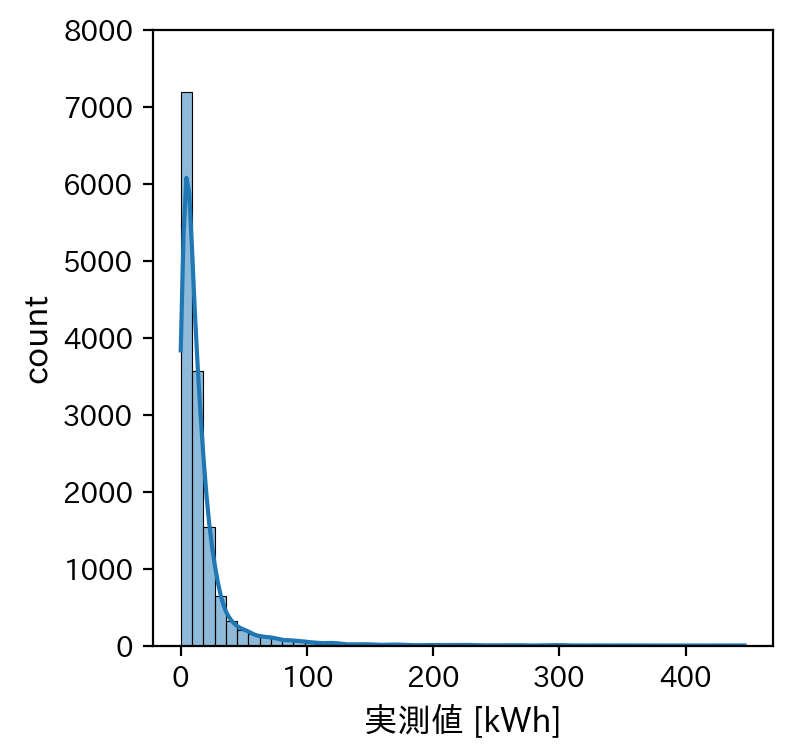

In [14]:
plt.figure(figsize=(4, 4),dpi=200)
sns.histplot(df_result['Real_Wh'], kde=True, bins=50)
plt.xlabel('実測値 [kWh]',fontsize=12)
plt.ylabel('count',fontsize=12)
plt.ylim(0,8000)
plt.show()

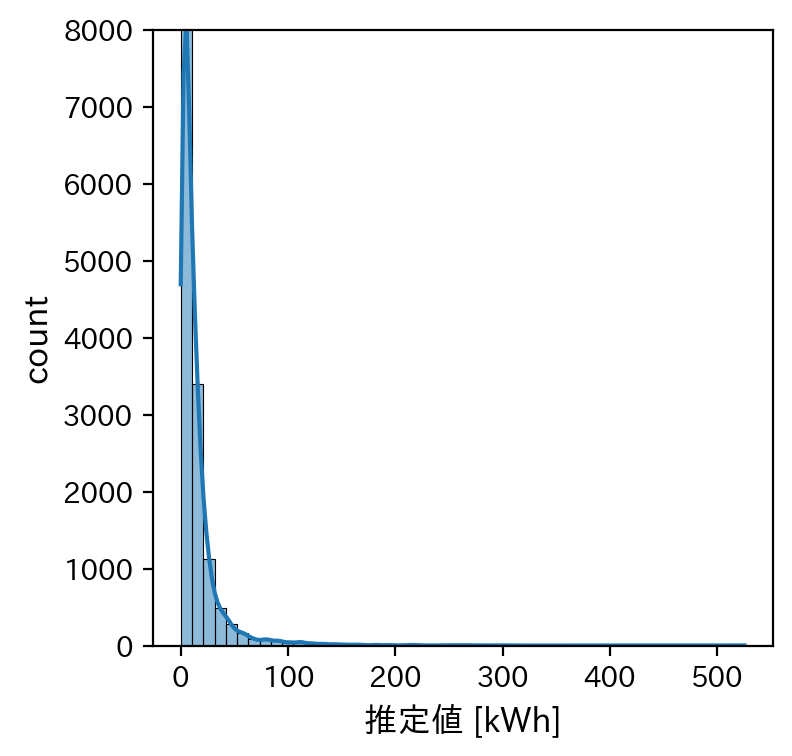

In [15]:
plt.figure(figsize=(4, 4),dpi=200)
sns.histplot(df_result['Pred_Wh'], kde=True, bins=50)
plt.xlabel('推定値 [kWh]',fontsize=12)
plt.ylabel('count',fontsize=12)
plt.ylim(0,8000)
plt.show()

R2が高くないが、分布の再現ができたと言える。

In [16]:
print('実測値平均:',df_result['Real_Wh'].mean(),'実測値分散:',df_result['Real_Wh'].var())
print('推定値平均:',df_result['Pred_Wh'].mean(),'推定値分散:',df_result['Pred_Wh'].var())

実測値平均: 15.957200083400766 実測値分散: 667.6596219452024
推定値平均: 14.524407561383548 推定値分散: 494.5743500208525


In [17]:
print('実測値αβ:',calculate_alpha_beta(df_result['Real_Wh'].mean(),df_result['Real_Wh'].var()))
print('推定値αβ:',calculate_alpha_beta(df_result['Pred_Wh'].mean(),df_result['Pred_Wh'].var()))

実測値αβ: (41.8406498919397, 0.3813803113625825)
推定値αβ: (34.05125805859313, 0.4265454021226152)
